# Your Community Eatery

## Welcome to your local (if you're in Phoenix) restaurant recommender! 

We are going to take a walk through the process of creating a recommender based on collaborative filtering of Yelp review data. Follow along here for the full story...

In [18]:
# Project specific modules
from src.pipeline import YourCommunityEatery
from website.src.functions import build_item_map, get_recs

# Avoid restarting Kernal each time we update modules
%load_ext autoreload
%autoreload 2

# The basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dictionaries for cleaning
from PyDictionary import PyDictionary
from vocabulary.vocabulary import Vocabulary as vb
import urbandict

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Surprise modeling
from surprise import SVD
import surprise
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split

# Persistance
import pickle

# Housekeeping
from io import StringIO
from datetime import datetime
import time
import requests

TypeError: an integer is required (got type bytes)

# Initial EDA

This dataset is actually too big to simply load into a Pandas dataframe (at least on my machine - 8 GB memory). Although I know people with 16 GB machines have loaded it successfully, so far I get memory errors when trying to load it onto a 16 GB AWS EC2 instance (and I'm still searching for an answer/solution on that). Regardless, we can do some initial EDA to just see what we have by using Spark!

In [15]:
# Read data in from files 
# There is quite a bit of data to load and it has to be filtered 
# based on some conditions to fit in memory, so this takes a while
# Expect over 80 total chunks to be read in...
pipe.read_data(data_dir_path='data/')

NameError: name 'pipe' is not defined

In [16]:
# Alternatively, we saved the results from above so that
# you can just load it from a file!
# This isn't super fast, but much better than the above.
# pipe.persist_subject_data()
pipe.bus_review_df = pd.read_json('data/bus_review_df.json', orient = 'records')

NameError: name 'pipe' is not defined

# Now that we have our data, let's delve into some additional EDA
#### At this point our data is saved in 'bus_review_df' which is an attribute of our pipe object

What time frame do these reviews span?

In [40]:
begin = pipe.bus_review_df.date.min()
end = pipe.bus_review_df.date.max()
print('These ratings range from {} to {}.'.format(begin.year, end.year))

These ratings range from 2005 to 2019.


Long span of data, nice! And what kind of distribution of reviews over time might we see for that duration?

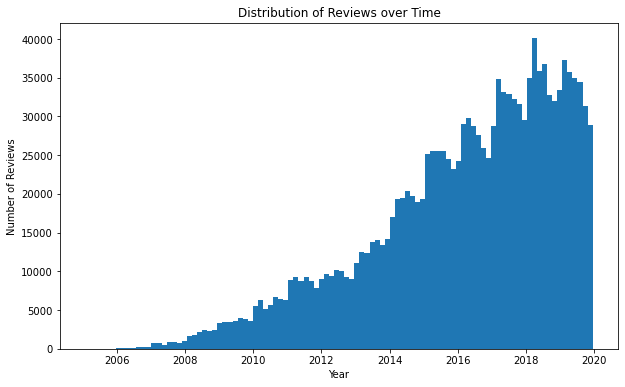

In [41]:
ax = pipe.bus_review_df.date.hist(bins = 100, figsize = (10, 6))
ax.grid(False)
ax.set_title('Distribution of Reviews over Time')
ax.set_xlabel('Year')
_ = ax.set_ylabel('Number of Reviews')

Look at that growth! Good for you, Yelp. Interesting trends after 2015, seasonality for reviews? Interesting...but out of our scope.

What is the distribution of number of users to have reviewed each restaurant? 


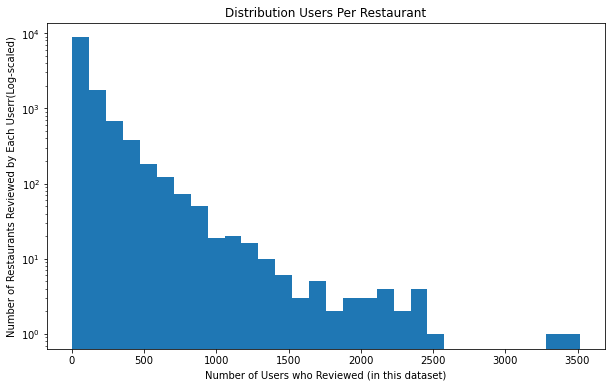

In [42]:
groups = pipe.bus_review_df.groupby('business_id')
ax = groups.user_id.nunique().hist(bins = 30, figsize = (10, 6))
ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Number of Users who Reviewed (in this dataset)')
ax.set_title('Distribution Users Per Restaurant')
_ = ax.set_ylabel('Number of Restaurants Reviewed by Each Userr(Log-scaled)')

Keeping in mind this is log-scaled on the y axis, this data appears to be exponentially distributed.


What is the distribution of reviews per user?


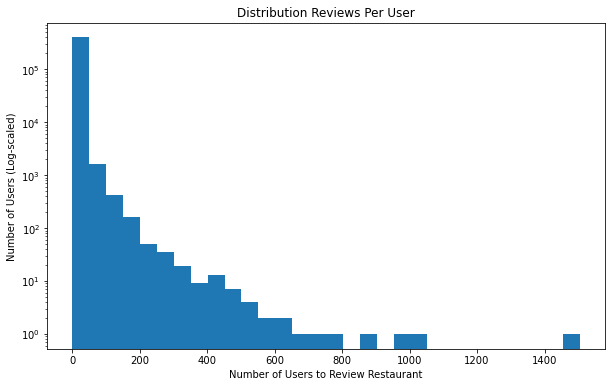

In [43]:
groups = pipe.bus_review_df.groupby('user_id')
ax = groups.review_id.nunique().hist(bins = 30, figsize = (10, 6))
ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Number of Users to Review Restaurant')
ax.set_title('Distribution Reviews Per User')
_ = ax.set_ylabel('Number of Users (Log-scaled)')

From the graph above, we are able to see that this is exponentially distributed. There are several users who have made significant numbers of reviews. Normally this might be cause for concern that their reviews are not legitimate; however, this dataset consists only of reviews that Yelp has validated and "recommended", so they are likely just very passionate about food. But skeptical scientists that we are, we'll not just take their word for it...ok, I admit that I'm mostly just curious to see what kind of stuff a person who writes over 1,200 reviews has to say.

Let's verify the text of the highest volume user to be sure they are not a bot. As shown below, only one user exceeded 1000 reviews and their id is 'ELcQDlf69kb-ihJfxZyL0A'. Feel free to adjust the index on the .iloc to see a few different reivews (just put in a number between 0 and 1277).

In [44]:
pipe.bus_review_df[pipe.bus_review_df.user_id == 'ELcQDlf69kb-ihJfxZyL0A'].text.iloc[356]

"Since I'm an ex-New Yorker, it was strange that I had not been to this pizza chain yet in my time in Arizona. Looking at the menu online, it just didn't seem like I should be spending north of $22 for a large pie with no topping. The lunch special was a better way to sample the slices and I had a couple of slices and a drink for $6.99. The slices in the case already had toppings, but if you order the special, you can get additional toppings at no charge on both slices and welcome mushrooms and peppers to the pepperoni party. The slices were good size, very foldable and it was a good lunch. The sauce might have had a touch too much garlic, but otherwise it now might be worth buying a pie, although the prices is high (should be $15 large with one topping). At this location, the staff and manager were both nice, checking on my food quality and telling me the history of NYPD. Will return."

Clearly, this is not a bot...just definitely someone who has a lot of time on their hands. Outlier though they may be, their reviews appear to be genuine, so we will graciously accept their contributions to our density.

## In  planning for a collaborative-filtering based recommender, we need to take a look at our density of reviews

In [45]:
density_pre = pipe.calculate_density()
print('The density of our data is {:.6f}'.format(density_pre))


The density of our data is 0.000297


Ouch, that is extremely low. Let's take a look at how we might improve that.

## For model training, let's consider trimming down our dataset to increase density

Normally, taking samples of your data to increase density is a non-starter, but we may have some clever ways of taking samples based on what we've learned so far. Let's start with getting later time periods, since we have far more reviews in the later segment of the data. We will use the "filter_by_review_date" method to modify our dataframe in place to only include reviews during-or-after a specified year.

In [46]:
pipe.filter_by_review_date(threshold = 2013)


In [47]:
density_time = pipe.calculate_density()
print('The density of our data is {:.6f}'.format(density_time))


The density of our data is 0.000300


# Start cleaning & prep for NLP

In [54]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(pipe.bus_review_df.text)

In [111]:
all_words = vectorizer.get_feature_names()
text_df = pd.DataFrame({'words':all_words})
text_df.sample(5)

,words
94568,lobby
59139,expellar
88555,kellz
149839,stab
163353,tumbling


# Determine words in regular dictionary

In [197]:
import requests
requests.get("https://www.espn.com/mens-college-basketball/")

TypeError: super(type, obj): obj must be an instance or subtype of type

In [160]:
dictionary = PyDictionary()
in_dict = []
record_frequency = 10
# start = 500
# stop = 

for idx, word in text_df.iterrows():
    meaning = dictionary.meaning(word[0], )
    if meaning is None:
        in_dict.append(0)
    else:
        in_dict.append(1)
    if (idx+1) % record_frequency == 0:
        print(f'Completed {idx} out of {len(text_df)} records. Saving results to file...')
        now = int(time.time())
        in_dict = pd.DataFrame({'in_dict':in_dict})
        in_dict.to_csv(f'./data/in_dict_{now}.csv')
#     if idx == 10:
#         break

AttributeError: module 'requests' has no attribute 'exceptions'

In [158]:
dictionary.meaning('asdf')

Error: The Following Error occured: list index out of range


/Users/Tyler/anaconda3/envs/yelp/lib/python3.7/site-packages/PyDictionary/utils.py:5: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 5 of the file /Users/Tyler/anaconda3/envs/yelp/lib/python3.7/site-packages/PyDictionary/utils.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  return BeautifulSoup(requests.get(url).text)


In [106]:
urbandict.define('butterfingered')

[{'word': 'butterfingered',
  'def': 'when a guy fingers',
  'example': 'me girlfriend',
  'category': 'unknown'}]

In [140]:
datetime.time()

TypeError: descriptor 'time' of 'datetime.datetime' object needs an argument

In [ ]:
# lda = LatentDirichletAllocation(n_components=5, random_state = 0)
# lda.fit(X)
# lda.transform(X[-2:])

# Time to Model

In [177]:
# For picking up a restarted notebook, you can load up a previously prepared df here
pipe.bus_review_df = pd.read_json('data/processed_df.json', orient = 'records')

In [180]:
df = pipe.bus_review_df[['uid', 'iid', 'review_stars']]

In [181]:
# And wipe the pipe to save memory
pipe.bus_review_df = None
pipe.review_df = None
pipe.business_df = None

In [182]:
# A reader is needed but only the rating_scale param is required.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df, reader)
trainset, testset = train_test_split(data, test_size = .05, random_state = 2)

In [ ]:
algs = [
        SVD(), 
        surprise.SlopeOne(), 
        surprise.NMF(),
        surprise.NormalPredictor(), 
        surprise.KNNBaseline(),
        surprise.KNNBasic(), 
        surprise.KNNWithMeans(),
        surprise.KNNWithZScore(), 
        surprise.BaselineOnly(),
        surprise.CoClustering()
        ]

# Iterate over all algorithms
for alg in algs:
    
    # Take a look at cross validation results to compare model types
    print(cross_validate(alg, data, measures=['RMSE'], cv=5, verbose=True))


Estimating biases using als...


NormalPredictor

* Mean RMSE on 5 splits: 1.827

In [24]:
naive_score = 1.827

In [159]:
KNN_model = pickle.load(open('models/top_grid_KNNBaseline_model.pkl', 'rb'))

In [161]:
KNN_params = pickle.load(open('model_results/top_grid_KNNBaseline_params.pkl', 'rb'))
KNN_params

{'k': 100,
 'min_k': 4,
 'bsl_options': {'method': 'als', 'reg': 1},
 'sim_options': {'name': 'cosine',
  'min_support': 1,
  'user_based': False,
  'shrinkage': 50},
 'random_state': 2}

In [25]:
KNN_score = pickle.load(open('model_results/top_grid_KNNBaseline_score.pkl', 'rb'))
KNN_score

1.1728866595837093

In [26]:
SVD_score = pickle.load(open('model_results/top_grid_SVD_score2.pkl', 'rb'))
SVD_score

1.1570598159339343

# Now we've determined a model that we prefer, let's get the similarity matrix from it

In [163]:
alg = surprise.KNNBaseline(KNN_params)

alg.fit(trainset)

NameError: name 'trainset' is not defined

In [ ]:
similarity_matrix = alg.compute_similarities()

In [ ]:
version = input('Please provide a distinguishing feature for this version:\n')
with open('data/similarity_matrix{}.pkl'.format(version), 'wb') as file:
    pickle.dump(similarity_matrix, file)

Text(0.5, 1.0, 'Model Performance Evaluation')

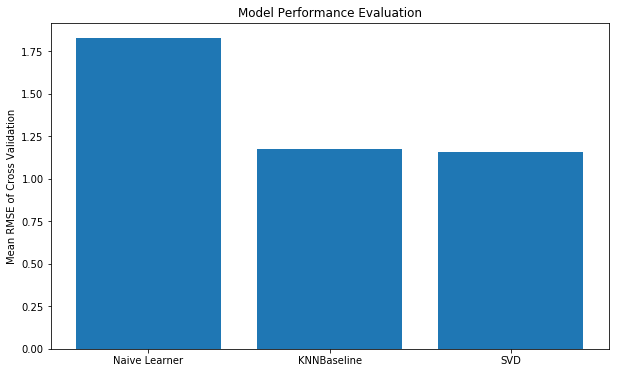

In [27]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.bar(['Naive Learner', 'KNNBaseline', 'SVD'], [naive_score, KNN_score, SVD_score])
ax.set_ylabel('Mean RMSE of Cross Validation')
ax.set_title('Model Performance Evaluation')

In [ ]:
# y = df['review_stars']
# X = df.drop('review_stars', axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# identifier_df_train = X_train[['user_id', 'business_id']]
# identifier_df_test = X_test[['user_id', 'business_id']]

#     # fit the model
#     alg_name = str(algorithm)[str(algorithm).find('ization')+8 : str(algorithm).find('obj')-1]
#     print('Fitting algorithm {}'.format(alg_name))
#     algorithm.fit(train_set)

#     # run predictions over
#     print('Predicting algorithm {}'.format(alg_name))
#     model_predictions = []
#     model_ratings = []
#     for idx, row in X_test.iterrows():
#         prediction = algorithm.predict(row[0], row[1])
#         model_predictions.append(prediction)
#         model_ratings.append(prediction[3])

#     # Pickle the models
#     pred_pkl_file = alg_name + '_predictions.pkl'
#     ratings_pkl_file = alg_name + '_ratings.pkl'
#     pickle.dump(model_predictions, open(pred_pkl_file, 'wb'))
#     pickle.dump(model_ratings, open(ratings_pkl_file, 'wb'))


# Make Recommendations

We are able to use simply the item-item similarity matrix to generate recommendations. Presently we are selecting the 3 restaurants with that are most similar to 4 restaurants of choice specified by the user.

In [ ]:
# Load similarities, bus_review_df, and item map to use for recommending
with open('website/models/item_map.pkl', 'rb') as file:
    item_map = pickle.load(file)

with open('website/models/KNNBaseline_similarities.pkl', 'rb') as file:
    similarities = pickle.load(file)

df = pd.read_json('data/processed_df.json', orient='records')
    
selection = ['In-N-Out Burger', "Chick-fil-A", 'The Stand', 'ATL Wings']
selection = ['The Stand', 'The Stand', 'The Stand', 'The Stand']
selection = ["Hungry Howie's Pizza", "In-N-Out Burger", "Chick-fil-A", "Chick-fil-A"]

In [ ]:
recommendations = get_recs(similarities, df, item_map, 3, selection)
recommendations

In [113]:
pipe.bus_review_df[pipe.bus_review_df.name == 'Beaver Choice']

,business_id,is_open,name,review_id,review_stars,state,iid,uid
123818,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,g1jg_DKzxZlCFjph14c5hg,5,AZ,709,7303
123820,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,X6sGqmNX2COiSbeL6jUP5Q,1,AZ,709,27863
123821,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,TaMsbo-MkCy7upr66cpvPg,5,AZ,709,20729
123822,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,FgD549Q2jrmG8cwty31aEw,5,AZ,709,27864
123825,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,xSf8g6JSvHwPNzAV-3TspA,5,AZ,709,27865
123826,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,HspPm_JC--aKoF4kCEZmAA,5,AZ,709,20984
123827,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,RTXpbliOwZny7gwdcURqvg,5,AZ,709,2041
123828,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,gNNpZV5kng-uhN4hZagKXQ,2,AZ,709,1523
123829,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,f4geLGpPyBPdOmKRnPgwlw,5,AZ,709,14744
123830,13KW8P5n1jAxxHB7Bl_obg,1,Beaver Choice,wFEhhGhbTRD2Pav0ImF9Lg,4,AZ,709,2172
